<a href="https://colab.research.google.com/github/philippe753/CNN_project/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# Import libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision 
from matplotlib import pyplot as plt
import gc
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling2D, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split 
import pickle
import cv2

In [5]:
# unzip the data frame containing the celebraties images
!unzip "/content/drive/MyDrive/AI_dataset/img_align_celeba.zip"

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [ ]:
# Importing data
data_Y = pd.read_excel("/content/drive/MyDrive/AI_dataset/list_attr_celeba.xlsx")
data_Y_columns = data_Y.iloc[0] # This contains the name of the features/columns of the dataframe.

In [ ]:
# Inspecting Data

# plot of the first 5 columns of the raw data
print("Raw data frame: \n")
print(data_Y.head(5))


data_Y = data_Y.replace(-1, 0) # Replace -1 for a 0.
# Deleating the first row, since it contains it just a interger refereing to the total number of imgs.
first_row = data_Y.iloc[0] #grab the first row for the header
data_Y = data_Y[1:] #take the data less the header row
data_Y.columns = first_row #set the header row as the df header
print('New data frame: \n')
data_Y.head(5)

Raw data frame: 

       202599        Unnamed: 1  ...      Unnamed: 39 Unnamed: 40
0           #  5_o_Clock_Shadow  ...  Wearing_Necktie       Young
1  000001.jpg                -1  ...               -1           1
2  000002.jpg                -1  ...               -1           1
3  000003.jpg                -1  ...               -1           1
4  000004.jpg                -1  ...               -1           1

[5 rows x 41 columns]
New data frame: 



,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
1,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
2,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
5,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
# download dataframe y
#pickle_out =  open("X.pickle", "bw")
#pickle.dump(training_data, pickle_out)
#pickle_out.close()

In [ ]:
# Load data frame y
data_Y = pickle.load(open("/content/drive/MyDrive/AI_dataset/y.pickle","rb"))
#data_X = pickle.load(open("X.pickle","rb"))

## Description of our data Frame
As we can see bellow, most examples are not bold, do not have Clock shadow, do not have bangs, do not have blond hair, do not have double chin, do not have eyeglasses, do not have a Goatee, nor gray_hair, nor mustache, nor male skin, nor have a recending hairline, nor have rosy cheeks,nor side burns, nor wearing a hat, nor wearing a necktie.

The first model we'll learn is a  simple logisitc neural network to try to predict attrative and non attrative people. 

In [ ]:
data_Y.describe()

,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599
unique,202599,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,093762.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
freq,1,180083,148509,103833,161153,198052,171890,153814,155083,154127,172616,192287,161027,173796,190936,193140,189406,189883,194100,124209,110410,118165,104657,194182,179270,169158,145032,193898,146389,186436,189284,191150,104930,160377,137855,164323,192781,106884,177686,187867,156734


## Randomly pick m images to be the training set.
Every image is flattened from a 3 dimmensional array to a 1-dimensional array and then standarized.

In [9]:
m =  2000 # number of examples to train the models
m_test = 200
num_features = 29103 # num of features for each image
train_X = np.zeros((num_features, m))
train_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
test_X = np.zeros((num_features, m_test))
test_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
# random numbers to selecet the training examples from the data frame.
rand_num = np.random.choice(range(202599), (m + m_test), replace=False) 
img_path = np.sort(glob.glob("img_align_celeba/*.*"))

for i in range(0, m + m_test):
    img = cv2.imread(img_path[rand_num[i]])
    # flat image into an array.
    img =  cv2.resize(img, (109, 89))
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    if i < m:
        train_X[:, i] = img_v[:, 0]
        # find the equivalent samples in data_Y.
        train_Y = pd.concat([train_Y, data_Y[data_Y['#'] == data_Y.iloc[rand_num[i]][0]]], ignore_index=True)
    elif i>=m:
        # same as above but for the test set.
        test_X[:, (i-m)] = img_v[:, 0]
        test_Y = pd.concat([test_Y, data_Y[data_Y['#'] == data_Y.iloc[rand_num[i]][0]]], ignore_index=True)

# Standardize data
train_X = train_X / 255.0
test_X = test_X / 255.0

# For now, we are only interested on the attribute attractive.
train_Y_attractive = train_Y['Attractive']
train_Y_attractive = train_Y_attractive.values.reshape((1, -1))
test_Y_attractive = test_Y['Attractive']
test_Y_attractive = test_Y_attractive.values.reshape((1, -1))

In [ ]:
#plt.imshow("img_align_celeba/000001")

In [ ]:
## Visualizing the training set. 
# Note that since our models were randomly chosen from the data frame, then this
# sample should be a good representation of the Data Frame.
print("train_X shape is: " + str(train_X.shape))
print("train_Y_attractive shape is: " + str(train_Y_attractive.shape))
print("test_X shape is: " + str(test_X.shape))
print("test_Y_attractive shape is: " + str(test_Y_attractive.shape))
print("Description of the features of the training set:")
train_Y.describe()

train_X shape is: (29103, 2000)
train_Y_attractive shape is: (1, 2000)
test_X shape is: (29103, 200)
test_Y_attractive shape is: (1, 200)
Description of the features of the training set:


,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,2000,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,156470.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
freq,1,1796,1458,1028,1623,1953,1715,1527,1583,1520,1706,1884,1595,1709,1886,1909,1859,1868,1919,1206,1092,1186,1013,1919,1784,1670,1415,1912,1454,1851,1865,1886,1032,1605,1339,1622,1892,1040,1752,1858,1571


## Perceptron model to predict attractive and non-attractive people.

We will implement the most basic implementation of a neural network to see how good a single layer neural network can accurately predict if a person is attractive or not. 

In [ ]:
class Perceptron:
      def __init__(self, learning_rate=0.01, num_ite=1000):
          self.learning_rate = learning_rate
          self.num_ite = num_ite

      def initialize_parameters(self, X):
          num_W = X.shape[0]
          W = np.random.randn(num_W, 1) * 0.01
          b = 0
          parameters = {"W": W, "b": b}
          return parameters

      def train(self, X, Y):
          params = self.initialize_parameters(X)
          for i in range(self.num_ite):
              print(i)
              W = params["W"]
              b = params["b"]
              print(W)
              print(b)
              A = self.forward_propagation(W, b, X)
              #print(A)
              cost = self.cost_function(A, Y)
              grads = self.backward_propagation(A, X, Y)
              params = self.update_rule(params, grads)      
          return params, grads, cost

      def forward_propagation(self, W, b, X):
          Z = np.dot(W.T, X) + b
          A = self.sigmoid_function(Z)
          return A
          
      def sigmoid_function(self, Z):
          Z = np.array(Z, dtype=np.float32)
          sig = 1/(1 + np.exp(-Z))
          return sig

      def cost_function(self, y_hat, Y):  
          m = y_hat.shape[1]  
          #print(y_hat)
          cost = (- 1 / m) * np.sum(Y * np.log(y_hat) + (1 - Y) * (np.log(1 - y_hat)))
          print('COST: ' + str(cost))
          return cost

      def backward_propagation(self, A, X, Y):
          dW = (1 / m) * np.dot(X, (A - Y).T)
          db = (1 / m) * np.sum(A - Y)
          grads = {"dW": dW, "db": db}
          return grads

      def update_rule(self, params, grads):
          dW = grads["dW"]
          db = grads["db"]
          W = params["W"]
          b = params["b"]
          W = W - self.learning_rate * dW
          b = b - self.learning_rate * db
          parameters = {"W": W, "b": b}
          return parameters
      
      def predict(self,params, test_X, test_Y):
        m = test_X.shape[1]
        A = self.forward_propagation(W, b, test_X)
        Y_prediction = np.where(A >0.5, 1, 0)
        return Y_prediction
          

In [ ]:

my_perceptron = Perceptron(learning_rate=0.01, num_ite=10)
params, grads, cost = my_perceptron.train(train_X, train_Y_attractive)
#parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [ ]:
# Implementing a 2 layer neural network

class TwoLayerNN:

    def __init__(self, learning_rate=0.01, num_ite=1000):
        self.learning_rate = learning_rate
        self.num_ite = num_ite
        self.num_x = num_features
        self.num_hidden = 20
        self.num_y = 1 # number of output units.
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None

    def initialize_parameters(self, num_x, num_hidden, num_y):
        self.W1 = np.random.randn(num_hidden, num_x) * 0.01
        self.b1 = np.zeros((num_hidden, 1))
        self.W2 = np.random.randn(num_y, num_hidden) * 0.01
        self.b2 = np.zeros((num_hidden, 1))
        parameters = {"W1": self.W1, "b1": self.b1, "W2": self.W2, "b2": self.b2}
        return parameters

    def fit(self, X, Y):
        grads = {}
        costs = []                              # to keep track of the cost
        # Initialize parameters
        parameters = self.initialize_parameters(self.num_x, self.num_hidden, self.num_y)
        for i in range(0, self.num_ite):
            # Forward propagation: with a relu and then sigmoid activation function
            A1, cache1 = self.linear_activation_forward(X, self.W1, self.b1, "relu")
            A2, cache2 = self.linear_activation_forward(A1, self.W2, self.b2, "sigmoid")

            # Cost function
            cost  = self.compute_cost(A2, Y)

            # Initializing backward propagation
            dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
            dA1, dW2, db2 = self.linear_activation_backward(dA2, cache2, "sigmoid")
            A0, dW1, db1 = self.linear_activation_backward(dA1, cache1, "relu")
            grads['dW1'] = dW1
            grads['db1'] = db1
            grads['dW2'] = dW2
            grads['db2'] = db2

            # Update the paramters.
            parameters = self.update_parameters(parameters, grads)
            self.W1 = parameters["W1"]
            self.b1 = parameters["b1"]
            self.W2 = parameters["W2"]
            self.b2 = parameters["b2"]

    def linear_forward(self, A, W, b):
        # Implement the linear part of a layer's forward propagation.
        Z = np.dot(W, A) + b
        cache = (A, W, b)
        return Z, cache

    def linear_activation_forward(self, A_prev, W, b, activation):
        # Implement the forward propagation for the LINEAR->ACTIVATION layer
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A = 1/(1 + np.exp(Z))
        elif activation == "relu":
            A = np.maximum(Z, 0)
        cache = (linear_cache, Z)  # note th
        return A, cache

    def linear_backward(self, dZ, cache):
        # linear backword propagation
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = (1/m) * np.dot(dZ, A_prev.T)
        db = (1/m) * np.sum(dZ, axis = 1, keepdims=True)
        print('dz: ' + str(dZ.shape))
        print('W.T: ' + str(W.T.shape))
        dA_prev = np.dot(W.T, dZ)

    def linear_activation_backward(self, dA, cache, activation):
        # Backward propagation.
        linear_cache, activation_cache = cache
        Z = activation_cache
        if activation == "relu":
          # Implement Back propagation witha relu activation function
            dZ = self.relu_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        elif activation == "sigmoid":
          # Implement Back propagation witha sigmoid activation function
            dsig = 1/(1+np.exp(-Z)) * (1 - 1/(1+np.exp(-Z)))
            dZ = dA * dsig    #= self.sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        return dA_prev, dW, db

    def compute_cost(self, AL, Y):
        cost = -(1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1 - Y), np.log(1-AL).T))

    def update_parameters(self, parameters, grads):
        # Update the weiths and bieses of each layer
        parameters = params.copy()
        L = len(parameters) // 2
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - self.learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - self.learning_rate * grads["db" + str(l+1)]
        return parameters

    def prediction(self, test_X, test_Y, parameters):
        A, W, b = parameters
        Z_1 = self.linear_activation_forward(test_X, self.W1, self.b1, "relu")
        A2, cache2 = self.linear_activation_forward(A1, self.W2, self.b2, "sigmoid")
        y_predict = A2
        # The unit step activation function returns only 1 or 0.
        return y_predict

      

In [ ]:
# Train neural network
#print("train_Y_Attractive shape: " + str(train_Y_attractive.shape))

my_nn = TwoLayerNN(learning_rate=0.01, num_ite=1000)
my_nn.fit(train_X, train_Y_attractive)

0
dz: (20, 2000)
W.T: (20, 1)


ValueError: ignored

In [ ]:
fit(train_X, train_Y_):

SyntaxError: ignored

In [ ]:
# Implementing a deep neural network

class DeepNN:

    def __init__(self, learning_rate=0.01, num_ite=1000):
        self.learning_rate = learning_rate
        self.num_ite = num_ite

    def initialize_parameters_deep(self, layer_dims):
        parameters = {}
        L = len(layer_dims) # number of layers in the network
        for l in range(1, L):
            parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        return parameters

    def fit(self, X, Y, layers_dims):
        costs = []                        
        # Initialize parameters
        parameters = self.initialize_parameters_deep(layers_dims)
        for i in range(0, self.num_ite):
            print(i)
            # Forward propagation: with a relu and then sigmoid activation function
            AL, caches = self.L_model_forward(X, parameters)
            # Cost function
            cost  = self.compute_cost(AL, Y)
            # Initializing backward propagation
            grads = self.L_model_backward(AL, Y, caches)
            # Update the paramters.
            parameters = self.update_parameters(parameters, grads, self.learning_rate)

            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        return parameters, costs 

    def linear_forward(self, A, W, b):
        # Implement the linear part of a layer's forward propagation. ( CHANGE )
        Z = np.dot(W, A) + b
        cache = (A, W, b)  
        return Z, cache

    def L_model_forward(self, X, parameters):
        # Implement the linear part of a layer's forward propagation.
        caches = []
        A = X
        L = len(parameters) // 2 
        # loop every layer
        for l in range(1, L):
            A_prev = A 
            A, cache = self.linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
            caches.append(cache)
        AL, cache = self.linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
        caches.append(cache)
        return AL, caches

    def linear_backward(self, dZ, cache):
        # Implement the linear portion of backward propagation for a single layer ( CHANGE )
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = (1./m) * np.dot(dZ, A_prev.T)
        db = (1./m) * np.sum(dZ, axis = 1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)        
        return dA_prev, dW, db

    def L_model_backward(self, AL, Y, caches):
        grads = {}
        L = len(caches) # the number of layers
        m = AL.shape[1]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(dAL, current_cache, "sigmoid")
        grads["dA" + str(L)] = dA_prev_temp
        grads["dW" + str(L)] = dW_temp
        grads["db" + str(L)] = db_temp
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
            grads["dA" + str(l + 1)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
        return grads

    def linear_activation_forward(self, A_prev, W, b, activation):
        # Implement the forward propagation for the LINEAR->ACTIVATION layer
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        Z = np.array(Z,dtype=np.float32)
        if activation == "sigmoid":
            A = 1/(1 + np.exp(-Z))
        elif activation == "relu":
            A = np.maximum(Z, 0)
        cache = (linear_cache, Z)  
        return A, cache

    def linear_activation_backward(self, dA, cache, activation):
        # Backward propagation.
        linear_cache, activation_cache = cache
        Z = activation_cache
        if activation == "relu":
          # Implement Back propagation witha relu activation function
            dsig = np.where(Z>0, 1, 0)
            dZ = dA * dsig
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        elif activation == "sigmoid":
          # Implement Back propagation witha sigmoid activation function
            dsig = 1/(1+np.exp(-Z)) * (1 - 1/(1+np.exp(-Z)))
            dZ = dA * dsig    #= self.sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        return dA_prev, dW, db

    def compute_cost(self, AL, Y):
        cost = -(1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1 - Y), np.log(1-AL).T))
        cost = np.squeeze(cost)
        return cost

    def update_parameters(self, params, grads, learning_rate):
        # Update the weiths and bieses of each layer
        parameters = params.copy()
        L = len(parameters) // 2
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        return parameters

    def prediction(self, test_X, test_Y, parameters):
        AL, caches = self.L_model_forward(test_X, parameters)
        y_hat = np.where(AL>=0.5, 1, 0)
        m = y_hat.shape[1]
        y_percentage = ( 1 - (1/m) * np.sum(abs(y_hat - test_Y)) ) * 100
        # The unit step activation function returns only 1 or 0.
        return y_hat, y_percentage

      

In [ ]:
layers_dims = [29103, 20, 7, 5, 1]
              
my_deepNN = DeepNN(learning_rate=0.0075, num_ite=2500)
parameters, costs = my_deepNN.fit(train_X, train_Y_attractive, layers_dims)
#parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

NameError: ignored

In [ ]:
y_hat, y_percentage = my_deepNN.prediction(test_X, test_Y_attractive, parameters)

In [ ]:
print(y_hat)
print(y_percentage)


In [ ]:
print(test_Y_attractive)
print(y_hat - test_Y_attractive)


In [ ]:
# Convolutional neural network
resnet = ResNet50(include_top=False, pooling='avg')
model = Sequential()
model.add(resnet)
model.add(Dense(1))
model.layers[0].trainable = False

_ = model(tf.zeros([1, 218,178, 3]))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (1, 2048)                 23587712  
_________________________________________________________________
dense_6 (Dense)              (1, 1)                    2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


## Convolutional Nueral Networks

In [ ]:
path = "/content/img_align_celeba" #np.sort(glob.glob("img_align_celeba/"))
#img_path = np.sort(glob.glob("img_align_celeba/*.*"))
#print(img_path)
training_data = []
def create_training_data():
    count = 0
    for img in np.sort(os.listdir(path)):
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)                       
        training_data.append(img_array)
        #plt.imshow(img_array)
        #plt.show()
        #break
        count += 1
        if count == 5000:
           print(count)
           break
    
create_training_data()

5000


In [ ]:
print('hi')

hi


In [ ]:
pickle_out =  open("X.pickle", "bw")
pickle.dump(training_data, pickle_out)
pickle_out.close()


In [ ]:
y = data_Y['Attractive'].head(5000)
y.describe()

count     5000
unique       2
top          1
freq      2561
Name: Attractive, dtype: int64

In [ ]:
X = torch.FloatTensor(training_data) #pickle.load(open("X.pickle", "rb"))
y = data_Y['Attractive'].head(5000)

X = X/255.0

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
             optimizer="adam", 
             metrics=['accuracy'])

model.fit(X, y, batch_size=32, validation_split=0.1)

ValueError: ignored

In [ ]:
print([X.shape[1:]])

In [4]:
## ---NEW SECTION---
# picking 75 and 75 attractive and unattractive people.
answers = data_Y['Attractive']
answers =answers.iloc[900:1050]
answers.mean()


0.5

In [16]:
from PIL import Image

imgs = []
valid_images = [".jpg",".gif",".png",".tga"]

img_path = np.sort(glob.glob("img_align_celeba/*.*"))

for i in range(1050):
    #img = cv2.imread(img_path[i])
    image = cv2.imread(img_path[i])
    img = np.array(image)
            
    imgs.append(img)

In [58]:
images_tensor = torch.FloatTensor(imgs)
img_transpose = torch.transpose(images_tensor, 1, 3) #torch.reshape(images_tensor, (1050, 3, 218, 178))
img_transpose = img_transpose.transpose(2, 3)
img_transpose.size()

torch.Size([1050, 3, 218, 178])

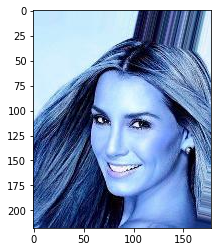

In [61]:
# plot an image to make sure that everything is in order. Note that pythong plots images in gbr not in rbg.
tensor_img = img_transpose[0]/255
plt.imshow(tensor_img.permute(1, 2, 0))

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(41820, 418)
        self.fc2 = nn.Linear(418, 44)
        self.fc3 = nn.Linear(44, 5)
        self.fc4 = nn.Linear(5, 2)

    def forward(self, x):
        x=x
        # (1) Input later "x = x"
        # (2) Hidden conv1 layer
#         x = self.conv1(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # (3) Hidden conv2 layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # (4) Hidden linear layer
        x = x.view(x.size(0),  41820)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [66]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=41820, out_features=418, bias=True)
  (fc2): Linear(in_features=418, out_features=44, bias=True)
  (fc3): Linear(in_features=44, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)

In [114]:
answers.astype('float64').values

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.])

In [116]:
answers_train = torch.from_numpy(answers.astype('float64').values)
answers_train2 = answers_train.long()

img_transpose_train = img_transpose[900:1050]
img_transpose_train.size()

torch.Size([150, 3, 218, 178])

In [79]:
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00000000000001)

In [80]:
for step in range(20):
    models = model(img_transpose_train)
    cross_entropy = cross_entropy_loss(models, answers_train2)
    total_cost = cross_entropy 
    
    print(total_cost)

    optimizer.zero_grad()
    total_cost.backward()
    optimizer.step()

tensor(0.5339, grad_fn=<NllLossBackward>)
tensor(0.4772, grad_fn=<NllLossBackward>)
tensor(0.6055, grad_fn=<NllLossBackward>)
tensor(0.5289, grad_fn=<NllLossBackward>)
tensor(0.5011, grad_fn=<NllLossBackward>)
tensor(0.4798, grad_fn=<NllLossBackward>)
tensor(0.5457, grad_fn=<NllLossBackward>)
tensor(0.4382, grad_fn=<NllLossBackward>)
tensor(0.5078, grad_fn=<NllLossBackward>)
tensor(0.5078, grad_fn=<NllLossBackward>)
tensor(0.4946, grad_fn=<NllLossBackward>)
tensor(0.5723, grad_fn=<NllLossBackward>)
tensor(0.5958, grad_fn=<NllLossBackward>)
tensor(0.4756, grad_fn=<NllLossBackward>)


KeyboardInterrupt: ignored

In [ ]:
_ , predicted = torch.max(models.data, 1)
predicted

In [ ]:
_ , predicted = torch.max(models.data, 1)

final = answers_train2.size(0)
correct = (predicted == answers_train2).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / final))
print('- CE : %2.2f,' % (cross_entropy.item()))

In [123]:
y = np.array(answers_train2)
X = np.array(images_tensor[900:1050]/255)
print(type(y))

<class 'numpy.ndarray'>


In [127]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first'))

#keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
             optimizer="adam", 
             metrics=['accuracy'])

model.fit(X, y, batch_size=32,epochs=10, validation_split=0.1)

Epoch 1/10
5/5 [==============================] - 2s 244ms/step - loss: 18.8208 - accuracy: 0.5102 - val_loss: 13.4149 - val_accuracy: 0.4000
Epoch 2/10
5/5 [==============================] - 1s 125ms/step - loss: 6.2221 - accuracy: 0.4962 - val_loss: 0.6143 - val_accuracy: 0.6000
Epoch 3/10
5/5 [==============================] - 1s 122ms/step - loss: 0.6432 - accuracy: 0.6034 - val_loss: 0.6310 - val_accuracy: 0.6000
Epoch 4/10
5/5 [==============================] - 1s 122ms/step - loss: 0.5233 - accuracy: 0.7292 - val_loss: 0.6196 - val_accuracy: 0.5333
Epoch 5/10
5/5 [==============================] - 1s 134ms/step - loss: 0.4171 - accuracy: 0.8372 - val_loss: 0.4937 - val_accuracy: 0.8667
Epoch 6/10
5/5 [==============================] - 1s 125ms/step - loss: 0.2930 - accuracy: 0.8731 - val_loss: 0.6795 - val_accuracy: 0.5333
Epoch 7/10
5/5 [==============================] - 1s 126ms/step - loss: 0.1839 - accuracy: 0.9620 - val_loss: 1.3864 - val_accuracy: 0.4000
Epoch 8/10
5/5 [==